***
# Background and Approach
***

PCam Data Source: https://github.com/basveeling/pcam</br>

In a previous notebook several VGG11-Net convolutional neural networks were investigated as applied to a reduced version of the PCam dataset. The smaller PCam dataset (consisting of 80,000 training images and approximately one third of the total training data) allowed for the evaluation of several models with significantly lower training times. That notebook can be found here:</br>

https://github.com/aprescot1977/Thinkful-projects/blob/main/Prescot_PCAM_VGG11_ReducedData.ipynb

</br>

This notebook aims to utilize the **full** PCam dataset and retrain three separate VGG11-Net models identified as the most optimal based on  performance metrics (accuracy, recall etc) and/or training and validation loss and accuracy curves. These models are retrained and evaluated in sections 9.1, 9.2, and 9.3 below. First, the entire dataset is reloaded and stored to jpeg file format if needs be.

***
# Setup Environment
***

***
## Import Required Libraries
***

In [1]:
import os
import cv2
import gzip
import sys
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from IPython.display import SVG
import VGGNet # user-defined function
import pydot as pyd
import time


import keras
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score


%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf

Using TensorFlow backend.


***
## Create Session for Running TensorFlow Operations
***

Here we will utilize the GPU version of TensorFlow and perform all (TF) operations on a 11GB NVIDIA GeForce RTX 2080 Ti GPU

In [2]:
print('TensorFlow version: {}'.format(tf.__version__) )

TensorFlow version: 2.0.0-rc1


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Check GPU connection
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


***
# Image File Organization
***

Data Source: The data is stored in gzipped HDF5 files and can be downloaded at the following link: https://github.com/basveeling/pcam</br>

Six separate files are provided as follows:
* camelyonpatch_level_2_split_train_x.h5.gz  (train images)
* camelyonpatch_level_2_split_train_y.h5.gz  (train labels)
* camelyonpatch_level_2_split_valid_x.h5.gz  (validation images)
* camelyonpatch_level_2_split_valid_y.h5.gz  (validation labels)
* camelyonpatch_level_2_split_test_x.h5.gz   (test images)
* camelyonpatch_level_2_split_test_y.h5.gz   (test labels)</br>

We first need to unzip these files, read the h5 files and store image data and labels to numpy arrays:

In [5]:
# If the unzipped files already exist, this cell will be skipped
directory = "raw data"
for filename in os.listdir(directory):
    if filename.endswith("gz"):
        filename_unzip = filename.replace(".gz", "")
        if not os.path.exists(os.path.join(directory, filename_unzip)):
            with gzip.open(os.path.join(directory, filename), "rb") as f_in:
                with open(os.path.join(directory, filename_unzip), "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

In [6]:
# Read h5 files and store to numpy arrays

x_train_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_train_x.h5'), 'r')
x_train = np.array(x_train_h5["x"][:])
y_train_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_train_y.h5"), "r")
y_train = np.array(y_train_h5["y"][:])

x_valid_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_valid_x.h5'), 'r')
x_valid = np.array(x_valid_h5["x"][:])
y_valid_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_valid_y.h5"), "r")
y_valid = np.array(y_valid_h5["y"][:])

x_test_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_test_x.h5'), 'r')
x_test = np.array(x_test_h5["x"][:])
y_test_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_test_y.h5"), "r")
y_test = np.array(y_test_h5["y"][:])

Print out dimensions to get an idea of image sizes etc:

In [7]:
print('Training Size   (Images)  : {}'.format(x_train.shape))
print('Training Size   (Label)   : {}'.format(y_train.shape))
print('Validation Size (Images)  : {}'.format(x_valid.shape))
print('Validation Size (Label)   : {}'.format(y_valid.shape))
print('Test Size       (Images)  : {}'.format(x_test.shape))
print('Test Size       (Label)   : {}'.format(y_test.shape))

Training Size   (Images)  : (262144, 96, 96, 3)
Training Size   (Label)   : (262144, 1, 1, 1)
Validation Size (Images)  : (32768, 96, 96, 3)
Validation Size (Label)   : (32768, 1, 1, 1)
Test Size       (Images)  : (32768, 96, 96, 3)
Test Size       (Label)   : (32768, 1, 1, 1)


* There are 80,000 images/labels for training, and 20,000 images/labels for both the validation and test datasets. 
* The native image resolution is 96 (pixels) x 96 (pixels) x 3 (RGB channels)

***
# Data Visualization
***

First, we will define a helper function that will display 25 (random) histopathological scans of human lymph node sections taken from the training set. The corresponding labels also will be displayed above each subplot.

In [8]:
def draw_images(x, y, num_of_rows, num_of_columns):
    f, ax = plt.subplots(nrows = num_of_rows, ncols = num_of_columns,
                         figsize = (5 * num_of_columns, 5 * num_of_rows))
    
    num_of_images = len(x)
    sample_size = num_of_rows * num_of_columns
    idx = np.random.randint(num_of_images, size = sample_size)
    
    images = x[idx, :]
    labels = y[idx, :]
    
    k = 0
    for i in range(0, num_of_rows):
        for j in range(0, num_of_columns):
            ax[i, j].imshow(images[k])
            ax[i, j].set_title(labels[k, 0, 0, 0], fontsize = 16)
            sns.set_style()
            k += 1
            
    plt.show()

0: no tumor tissue
1: has tumor tissue


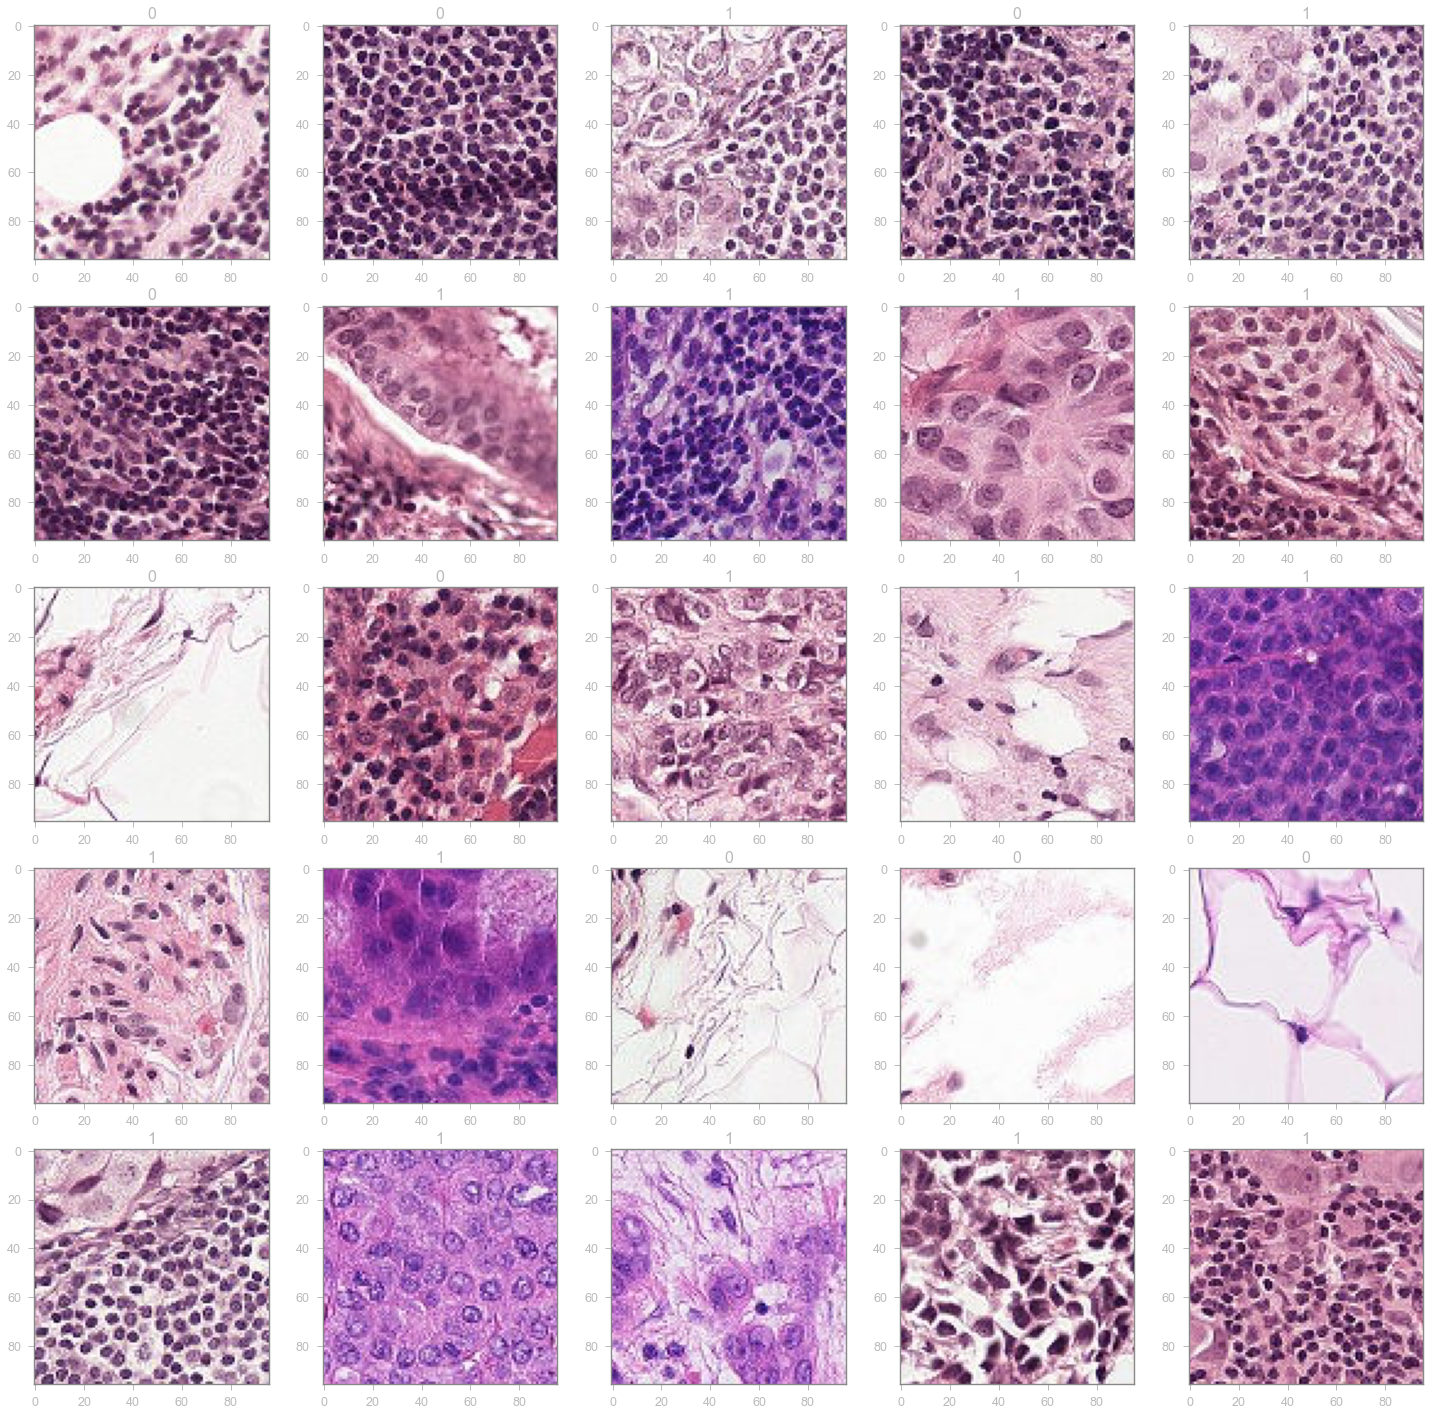

In [9]:
sns.set_style()
print("0: no tumor tissue")
print("1: has tumor tissue")
draw_images(x_train, y_train, 5, 5)

***
# Write Files to JPEG Format
***

The following cell contains conditional statements that check for the presence of train, validation, and test directories within the specified local base directory. If these have already been created (i.e. the first execution) then this none of the  folders will be recreated.

In [10]:
base_dir = 'cancer data'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

valid_dir = os.path.join(base_dir, 'valid')
if not os.path.exists(valid_dir):
    os.mkdir(valid_dir)
    
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)

no_tumor_tissue = os.path.join(valid_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(valid_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)
    
no_tumor_tissue = os.path.join(test_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(test_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)

***
The following cell then compares the length of the x_train, x_valid, and x_test numpy arrays with the number of files within the corresponding local base directory. If the lengths match, then jpeg files will not be rewritten.
***

In [11]:
if len(x_train) != len(os.listdir('cancer data/train/a_no_tumor_tissue')) + len(os.listdir('cancer data/train/b_has_tumor_tissue')):
    for i in range(len(x_train)):
        label = ""
        target = y_train[i, 0, 0, 0]
        if target == 0:
            label = 'a_no_tumor_tissue'
        elif target == 1:
            label = 'b_has_tumor_tissue'
        if label is not "":
            destination = os.path.join(train_dir, label, "{0}.jpg".format(i))
            cv2.imwrite(destination, x_train[i])

if len(x_valid) != len(os.listdir('cancer data/valid/a_no_tumor_tissue')) + len(os.listdir('cancer data/valid/b_has_tumor_tissue')):
    for i in range(len(x_valid)):
        label = ""
        target = y_valid[i, 0, 0, 0]
        if target == 0:
            label = 'a_no_tumor_tissue'
        elif target == 1:
            label = 'b_has_tumor_tissue'
        if label is not "":
            destination = os.path.join(valid_dir, label, "{0}.jpg".format(i))
            cv2.imwrite(destination, x_valid[i])
        
if len(x_test) != len(os.listdir('cancer data/test/a_no_tumor_tissue')) + len(os.listdir('cancer data/test/b_has_tumor_tissue')):
    for i in range(len(x_test)):
        label = ""
        target = y_test[i, 0, 0, 0]
        if target == 0:
            label = 'a_no_tumor_tissue'
        elif target == 1:
            label = 'b_has_tumor_tissue'
        if label is not "":
            destination = os.path.join(test_dir, label, "{0}.jpg".format(i))
            cv2.imwrite(destination, x_test[i])

***
# Definte Image Size, Batch Size, Epochs
***

In [12]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

number_train_samples = len(x_train)
number_valid_samples = len(x_valid)

train_batch_size = 64
valid_batch_size = 64
epochs = 40

train_steps = np.ceil(number_train_samples / train_batch_size)
valid_steps = np.ceil(number_valid_samples / valid_batch_size)

print('Number of epochs = {}'.format(epochs))
print('Training steps   = {}'.format(int(train_steps)))
print('Validation steps = {}'.format(int(valid_steps)))

Number of epochs = 40
Training steps   = 4096
Validation steps = 512


***
# Define Train, Validation, and Testing Data Directories for Processing
***

In [13]:
train_path = 'cancer data/train'
valid_path = 'cancer data/valid'
test_path = 'cancer data/test'

datagen = ImageDataGenerator(rescale = 1.0/255) # Image preprocessing. Scaling RGB data.

train_gen = datagen.flow_from_directory(train_path,
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size = train_batch_size,
                                        class_mode = 'categorical')

valid_gen = datagen.flow_from_directory(valid_path,
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size = valid_batch_size,
                                        class_mode = 'categorical')

test_gen = datagen.flow_from_directory(test_path,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size = 1,
                                       class_mode = 'categorical',
                                       shuffle = False)

Found 262144 images belonging to 2 classes.
Found 32768 images belonging to 2 classes.
Found 32768 images belonging to 2 classes.


***
# Helper Functions
***

## Summarize Diagnostics

In [14]:
# plot diagnostic learning curves
def summarize_diagnostics(history, title):
    sns.set_style('darkgrid')

    # find maximum validation accuracy for vertical line display
    line = history.history['val_accuracy'].index(max(history.history['val_accuracy']))+1
    
    # loss plots
    plt.figure(figsize = (12, 10))
    plt.subplot(211)
    x_axis = list(range(1, len(history.history['accuracy']) + 1))
    sns.lineplot(x = x_axis, y = history.history['loss'],     color = 'b',      label = 'Training loss')
    sns.lineplot(x = x_axis, y = history.history['val_loss'], color = 'orange', label = 'Validation loss')
    plt.axvline(line, c = 'gray', linestyle = ':')
    plt.title('Model: ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # accuracy plots
    plt.subplot(212)
    sns.lineplot(x = x_axis, y = history.history['accuracy'],     color = 'b',      label = 'Training accuracy')
    sns.lineplot(x = x_axis, y = history.history['val_accuracy'], color = 'orange', label = 'Validation accuracy')    
    plt.axvline(line, c = 'gray', linestyle = ':')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.savefig(title + '_diagnostics.png', facecolor='w')

## Performance Report and Confusion Matrix Calculation

In [15]:
def prediction_report(predictions, classes, test_gen):
    print(test_gen.class_indices)
    df_preds = pd.DataFrame(predictions, columns = classes)
    df_preds.head()
    y_true_labels = test_gen.classes
    y_predicted_labels = predictions.argmax(axis = 1)
    c_report = classification_report(y_true_labels, y_predicted_labels, target_names = classes)
    c_matrix = confusion_matrix(y_true_labels, y_predicted_labels)
    
    print(c_report)
    
    return c_matrix

## Confusion Matrix with ROC/AUC Plotter

In [16]:
def seaborn_cm(data_cm, bin0, bin1, title, test_gen, predictions): # Uses Seaborn's heatmap
    # Confusion Matrix
    plt.figure(figsize=(18,8))
    plt.subplot(121)
    sns.set_style('whitegrid')
    accuracy = np.trace(data_cm)/float(np.sum(data_cm))
    misclass = 1-accuracy
    cm2plot = pd.DataFrame(data_cm.T, columns = [bin0, bin1], index = [bin0, bin1])
    sns.heatmap(cm2plot, square = True, annot = True, fmt = "d", linecolor = 'grey', linewidths = 1, cmap = 'YlGnBu')
    plt.ylabel('Predicted Value')
    plt.xlabel('Ground Truth\n\naccuracy = {:0.3f}        misclass = {:0.3f}'.format(accuracy, misclass))
    plt.title('{}'.format(title))
    
    # ROC Plot
    plt.subplot(122)
    fpr, tpr, thresholds = roc_curve(test_gen.classes, predictions[:,1])
    auc_model = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(fpr, tpr, 'k', label='area = {:.3f}'.format(auc_model))
    plt.xlabel('False positive rate (1-specificity)')
    plt.ylabel('True positive rate (sensitivity)')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    plt.savefig(title + '_confusion_plot.png', facecolor='w')
    
    ''' remove comments below if CM has top and bottom clipped '''
    #b, t = plt.ylim() # find the values for bottom and top
    #b += 0.5 # Add 0.5 to the bottom
    #t -= 0.5 # Subtract 0.5 from the top
    #plt.ylim(b, t) # update the ylim(bottom, top) values

## Model Plotter

In [17]:
def model_plotter(model, filename):
    keras.utils.vis_utils.pydot = pyd
    plot_model(model, to_file = filename)
    SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

***
# Visual Geometry Group (VGG) Net
***

To keep the present notebook succinct, we will use a user-defined VGG11Net.py function to load our various CNNs (function source: https://drive.google.com/file/d/1BlPIOdnlpSE5zz-__KK2NGuLiSy94I4R/view?usp=sharing). First, we will investigate the performance of a simple VGG11-Net CNN architecture characterized by the follwing parameters:</br>

epochs = 40</br>

batchsize = 64</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.9</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = softmax</br>



***
## Basic VGG-11
***

### Instantiate and Plot Model

In [18]:
import VGG11Net
# Instantiate Model
model_vgg11 = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
model_vgg11.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 256)      

In [19]:
# Plot model
model_plotter(model_vgg11, 'model_vgg11.png')

### Specify Model Filename and Create Checkpoint

In [20]:
filepath = "model_vgg11.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [21]:
start_time = time.time()
history_vgg11 = model_vgg11.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
4096/4096 [==============================] - 5976s 1s/step - loss: 14.8030 - accuracy: 0.7944 - val_loss: 13.5330 - val_accuracy: 0.8085

Epoch 00001: val_accuracy improved from -inf to 0.80847, saving model to model_vgg11.h5
Epoch 2/40
4096/4096 [==============================] - 352s 86ms/step - loss: 12.5649 - accuracy: 0.8379 - val_loss: 11.6707 - val_accuracy: 0.7714

Epoch 00002: val_accuracy did not improve from 0.80847
Epoch 3/40
4096/4096 [==============================] - 235s 57ms/step - loss: 10.6761 - accuracy: 0.8675 - val_loss: 9.9377 - val_accuracy: 0.8175

Epoch 00003: val_accuracy improved from 0.80847 to 0.81754, saving model to model_vgg11.h5
Epoch 4/40
4096/4096 [==============================] - 224s 55ms/step - loss: 9.0772 - accuracy: 0.8899 - val_loss: 8.5160 - val_accuracy: 0.8450

Epoch 00004: val_accuracy improved from 0.81754 to 0.84503, saving model to 

### Model Diagnostics

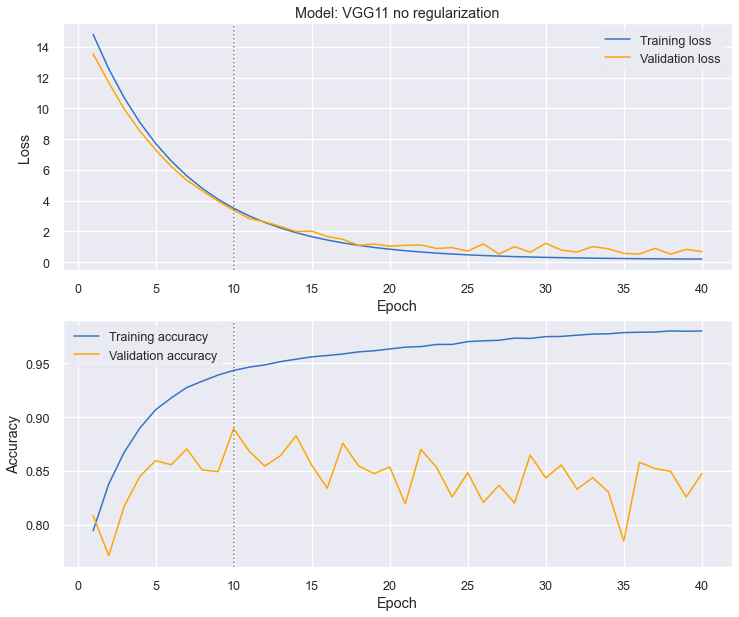

In [22]:
summarize_diagnostics(history_vgg11, 'VGG11 no regularization')

### Predictions and Report on Test Data

In [23]:
# Load model parameters
filepath = "model_vgg11.h5"
model_vgg11.load_weights(filepath)
predictions = model_vgg11.predict_generator(test_gen, steps = len(x_test), verbose = 1)

32768/32768 [==============================] - 148s 5ms/step


In [24]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.80      0.90      0.85     16391
has tumor tissue       0.89      0.77      0.82     16377

        accuracy                           0.84     32768
       macro avg       0.84      0.84      0.84     32768
    weighted avg       0.84      0.84      0.84     32768



### Confusion Matrix and ROC 

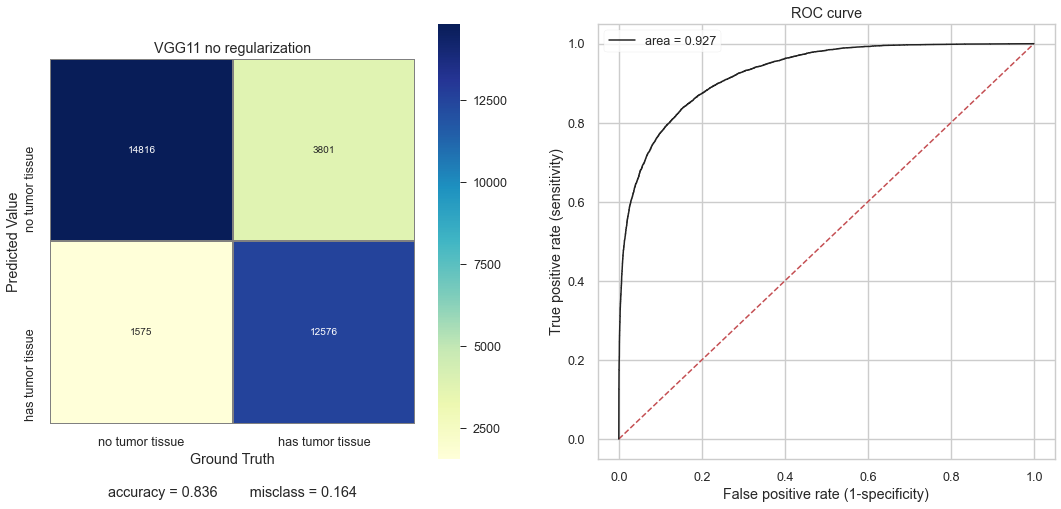

<Figure size 432x288 with 0 Axes>

In [25]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 no regularization', test_gen, predictions)

***
## Basic VGG-11 with Dropout
***


epochs = 40</br>

batchsize = 64</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.9</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = softmax</br>

dropout = True (20%)

### Instantiate and Plot Model

In [26]:
import VGG11Net
# Instantiate Model
model_vgg11_do = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), dropout=True)
model_vgg11_do.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 256)      

In [27]:
# Plot model
model_plotter(model_vgg11_do, 'model_vgg11_do.png')

### Specify Model Filename and Create Checkpoint

In [28]:
filepath = "model_vgg11_do.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [29]:
start_time = time.time()
history_vgg11_do = model_vgg11_do.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Epoch 1/40
4096/4096 [==============================] - 242s 59ms/step - loss: 14.8391 - accuracy: 0.7608 - val_loss: 13.6673 - val_accuracy: 0.7741

Epoch 00001: val_accuracy improved from -inf to 0.77411, saving model to model_vgg11_do.h5
Epoch 2/40
4096/4096 [==============================] - 239s 58ms/step - loss: 12.6053 - accuracy: 0.8082 - val_loss: 11.8672 - val_accuracy: 0.7539

Epoch 00002: val_accuracy did not improve from 0.77411
Epoch 3/40
4096/4096 [==============================] - 237s 58ms/step - loss: 10.7271 - accuracy: 0.8302 - val_loss: 10.1039 - val_accuracy: 0.7806

Epoch 00003: val_accuracy improved from 0.77411 to 0.78064, saving model to model_vgg11_do.h5
Epoch 4/40
4096/4096 [==============================] - 238s 58ms/step - loss: 9.1365 - accuracy: 0.8471 - val_loss: 8.6890 - val_accuracy: 0.8028

Epoch 00004: val_accuracy improved from 0.78064 to 0.80276, saving model to model_vgg11_do.h5
Epoch 5/40
4096/4096 [==============================] - 240s 59ms/st

4096/4096 [==============================] - 246s 60ms/step - loss: 0.2460 - accuracy: 0.9494 - val_loss: 0.5524 - val_accuracy: 0.8765

Epoch 00039: val_accuracy did not improve from 0.89844
Epoch 40/40
4096/4096 [==============================] - 274s 67ms/step - loss: 0.2436 - accuracy: 0.9485 - val_loss: 0.6445 - val_accuracy: 0.8751

Epoch 00040: val_accuracy did not improve from 0.89844
Run time for 20 epochs: 163.67 minutes


### Model Diagnostics

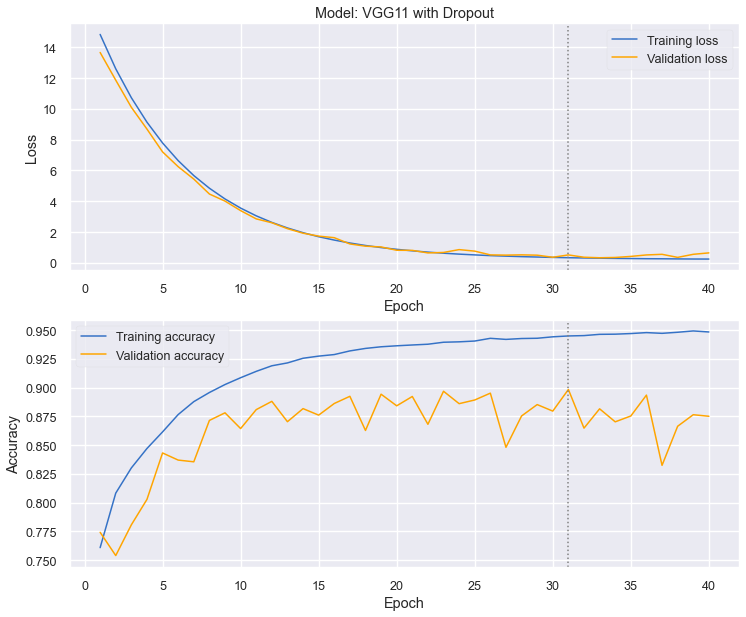

In [30]:
summarize_diagnostics(history_vgg11_do, 'VGG11 with Dropout')

### Predictions and Report on Test Data

In [31]:
# Load model parameters
model_vgg11_do.load_weights(filepath)
predictions = model_vgg11_do.predict_generator(test_gen, steps = len(x_test), verbose = 1)

32768/32768 [==============================] - 97s 3ms/step


In [32]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.83      0.90      0.87     16391
has tumor tissue       0.89      0.82      0.85     16377

        accuracy                           0.86     32768
       macro avg       0.86      0.86      0.86     32768
    weighted avg       0.86      0.86      0.86     32768



### Confusion Matrix and ROC

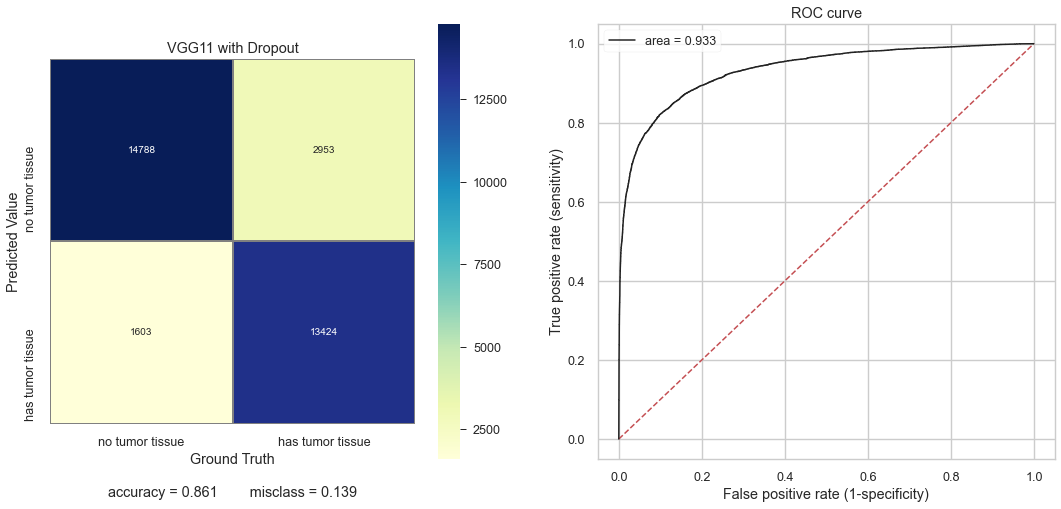

<Figure size 432x288 with 0 Axes>

In [33]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 with Dropout', test_gen, predictions)

***
## Basic VGG-11 with Dropout and Batch Size = 32
***

epochs = 40</br>

batchsize = 32</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.9</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = softmax</br>

dropout = True (20%)



In [34]:
train_batch_size = 32
valid_batch_size = 32
epochs = 40

train_steps = np.ceil(number_train_samples / train_batch_size)
valid_steps = np.ceil(number_valid_samples / valid_batch_size)

print('Number of epochs = {}'.format(epochs))
print('Training steps   = {}'.format(int(train_steps)))
print('Validation steps = {}'.format(int(valid_steps)))

Number of epochs = 40
Training steps   = 8192
Validation steps = 1024


### Instantiate and Plot Model

In [35]:
import VGG11Net
# Instantiate Model
model_vgg11_do_smallbatch = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), dropout=True)
model_vgg11_do_smallbatch.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 256)      

### Specify Model Filename and Create Checkpoint

In [36]:
filepath = "model_vgg11_do_smallbatch.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [37]:
start_time = time.time()
history_vgg11_do_smallbatch= model_vgg11_do_smallbatch.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Epoch 1/40
8192/8192 [==============================] - 535s 65ms/step - loss: 18.4908 - accuracy: 0.5720 - val_loss: 11.8361 - val_accuracy: 0.7424

Epoch 00001: val_accuracy improved from -inf to 0.74237, saving model to model_vgg11_do_smallbatch.h5
Epoch 2/40
8192/8192 [==============================] - 480s 59ms/step - loss: 9.9775 - accuracy: 0.8152 - val_loss: 8.5543 - val_accuracy: 0.7536

Epoch 00002: val_accuracy improved from 0.74237 to 0.75363, saving model to model_vgg11_do_smallbatch.h5
Epoch 3/40
8192/8192 [==============================] - 478s 58ms/step - loss: 7.2317 - accuracy: 0.8597 - val_loss: 6.1167 - val_accuracy: 0.8329

Epoch 00003: val_accuracy improved from 0.75363 to 0.83295, saving model to model_vgg11_do_smallbatch.h5
Epoch 4/40
8192/8192 [==============================] - 481s 59ms/step - loss: 5.2682 - accuracy: 0.8846 - val_loss: 4.6260 - val_accuracy: 0.8546

Epoch 00004: val_accuracy improved from 0.83295 to 0.85461, saving model to model_vgg11_do_sma

8192/8192 [==============================] - 489s 60ms/step - loss: 0.2041 - accuracy: 0.9578 - val_loss: 0.4385 - val_accuracy: 0.8972

Epoch 00039: val_accuracy did not improve from 0.90186
Epoch 40/40
8192/8192 [==============================] - 475s 58ms/step - loss: 0.2035 - accuracy: 0.9579 - val_loss: 0.3620 - val_accuracy: 0.8749

Epoch 00040: val_accuracy did not improve from 0.90186
Run time for 20 epochs: 332.69 minutes


### Model Diagnostics

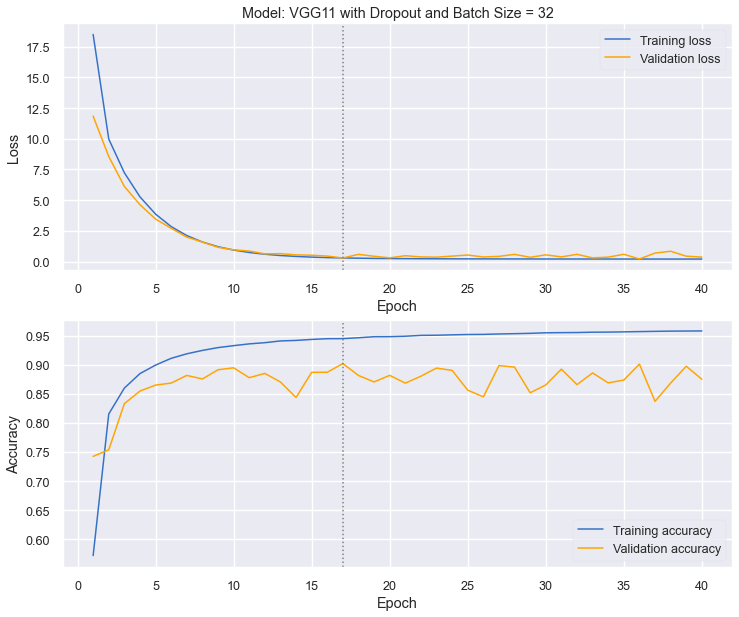

In [38]:
summarize_diagnostics(history_vgg11_do_smallbatch, 'VGG11 with Dropout and Batch Size = 32')

### Predictions and Report on Test Data

In [39]:
# Load model parameters
model_vgg11_do_smallbatch.load_weights(filepath)
predictions = model_vgg11_do_smallbatch.predict_generator(test_gen, steps = len(x_test), verbose = 1)

32768/32768 [==============================] - 97s 3ms/step


In [40]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.81      0.91      0.86     16391
has tumor tissue       0.89      0.79      0.84     16377

        accuracy                           0.85     32768
       macro avg       0.85      0.85      0.85     32768
    weighted avg       0.85      0.85      0.85     32768



### Confusion Matrix and ROC

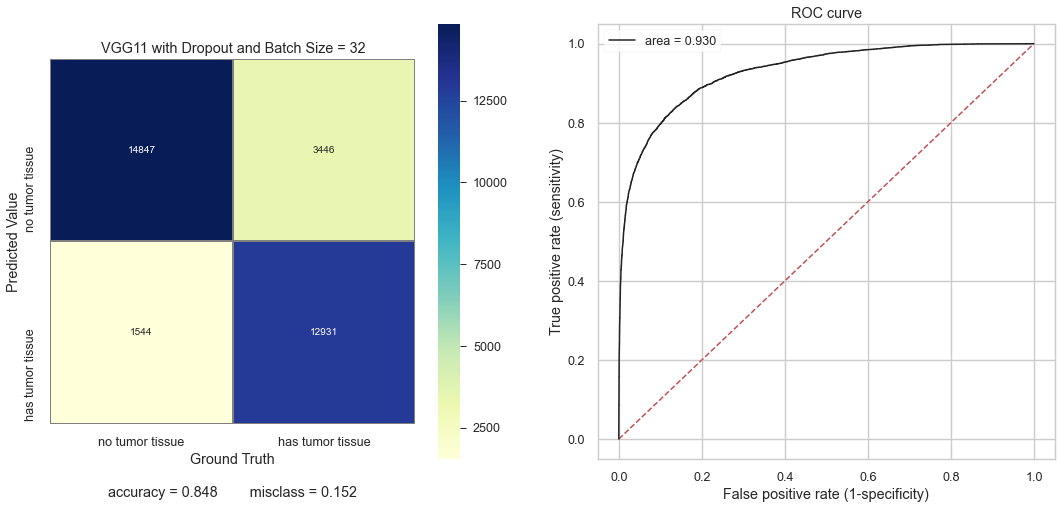

<Figure size 432x288 with 0 Axes>

In [41]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 with Dropout and Batch Size = 32', test_gen, predictions)

***
# Model Summary
***

Generate a tabulated data summary in Pandas to facilitate data analysis

In [44]:
import pandas as pd
data = {'CNN Architecture': ['VGG-11']*3,
        'Regularization': ['None', 'Dropout (20%)', 'Dropout (20%)'],
        'Optimizer': ['SGD', 'SGD', 'SGD'],
        'Batch Size': [64, 64, 32],
        'Epochs': [40]*3,
        'Hidden layer activation function': ['ReLU', 'ReLU', 'ReLU'],
        'Output activation function': ['softmax', 'softmax', 'softmax'],
        'Accuracy': [0.84, 0.86, 0.85],
        'Recall (tumor +ve)': [0.77, 0.82, 0.79],
        'ROC AUC': [0.93]*3}

results_dict = pd.DataFrame.from_dict(data)
results_dict

CNN Architecture Regularization Optimizer  Batch Size  Epochs  \
0           VGG-11           None       SGD          64      40   
1           VGG-11  Dropout (20%)       SGD          64      40   
2           VGG-11  Dropout (20%)       SGD          32      40   

  Hidden layer activation function Output activation function  Accuracy  \
0                             ReLU                    softmax      0.84   
1                             ReLU                    softmax      0.86   
2                             ReLU                    softmax      0.85   

   Recall (tumor +ve)  ROC AUC  
0                0.77     0.93  
1                0.82     0.93  
2                0.79     0.93

## Noteworthy Observations

**Basic VGG11-Net (section 9.1)**</br>

</br>

    Compared to the smaller training dataset:
    - accuracy for the full dataset decreased from 98 to 84%
    - recall (+ve label) for the full dataset decreased from 99 to 77%
    - comparable overfitting  observed as demonstrated by the training and validation loss and accuracy curves
    
**Basic VGG11-Net with Dropout (section 9.2)**</br>

</br>

    Compared to the smaller training dataset:
    - accuracy for the full dataset decreased from 93 to 86%
    - recall (+ve label) for the full dataset decreased from 95 to 82%
    - greater degree of overfitting observed as demonstrated by the training and validation loss and accuracy curves (13% vs 5%)

**Basic VGG11-Net with Dropout and Batch Size = 32 (section 9.3)**</br>

</br>

    Compared to the smaller training dataset:
    - accuracy for the full dataset decreased from 95 to 85%
    - recall (+ve label) for the full dataset decreased from 96 to 79%
    - comparable overfitting  observed as demonstrated by the training and validation loss and accuracy curves
    
</br>
Comparable ROC AUC metrics observed for all three models

# Conclusions and Future Work

The VGG11-Net model employing dropout (20%) and a batch size of 64 yielded the most optimal performance metrics. Retraining all three models using the full dataset yielded similar accuracy and ROC AUC metrics. However, the model from section 9.2 showed the least hit with respect to positive label recall, which is a critical metric when considering medical diagnostic classification. 

Although the current capstone project made use of the GPU version of Tensorflow and a relatively powerful single GPU (11 GB), training times should be considered. For example, for the smaller training dataset, training times ranged between 1-2 hours. Similarly, for the full dataset, training times ranged between approximately 3-5 hours.</br>

</br>

The associated training times were the primary driver for exploring various models using a reduced dataset. However, the arbitrary selection of 80000 validation images, 20000 validation images, and 20000 test images may be problematic for several reasons. One major issue might be the test data selected for model evaluation in the reduced dataset more closely resembled the training data images than is the case for the full dataset explored above. Moving forward, access to additional computing resources (especially multiple GPUs for training purposes) would allow for training models using the full complement of PCam data, exploration of many more hyperparameter tunings (e.g. learning rates, momentum, CNN specifics such as depth of convolutional filters, stride etc), as well as cross-validation procedures.</br>

</br>

Nevertheless, further development of computer vision with CNN technology holds great promise for automatic detection of abnormalities present within histopathological scans of biological tissues. Optimized CNNs have the potential to provide a first line of defence for detection of malignant cells in histopathological samples, dramatically accelerating diagnostic readout times and eliminating human error and misclassification. Deploying these types of models into production could involve several different approaches. One method would be to develop a website with a simple user interface that allows customers to upload batches of histological image data. The CNN model would be implemented at the backend providing rapid classifications and an array of visualizations/performance metrics.